In [1]:
import pandas as pd
import numpy as np

from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Ensure nltk dependencies are available
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load dataset
train = pd.read_csv('../date/train_data_cleaned.csv')
test = pd.read_csv('../date/test_data_cleaned.csv')
val = pd.read_csv('../date/val_data_cleaned.csv')

In [4]:
# Preprocessing function
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

In [5]:
# Apply preprocessing
for df in [train, val, test]:
    df['processed_text'] = df['text'].apply(preprocess_text)
    df['processed_title'] = df['title'].apply(preprocess_text)
    df['combined_text'] = df['processed_title'] + " " + df['processed_text']

In [6]:
# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['combined_text'])

X_train = pad_sequences(tokenizer.texts_to_sequences(train['combined_text']), maxlen=100, padding='post')
X_val = pad_sequences(tokenizer.texts_to_sequences(val['combined_text']), maxlen=100, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(test['combined_text']), maxlen=100, padding='post')

In [7]:
# Train Word2Vec model
w2v_model = Word2Vec(sentences=[text.split() for text in train['combined_text']], vector_size=100, window=5, min_count=1, workers=4)

# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [8]:
# K-Means Clustering on Word Embeddings
word_vectors = w2v_model.wv[w2v_model.wv.index_to_key]
kmeans = KMeans(n_clusters=2, random_state=42)  # Adjust clusters if needed
kmeans.fit(word_vectors)
labels = kmeans.labels_

In [9]:
# Build RNN Model for Sequence Embedding
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=100, trainable=False),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.4),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(100, activation='relu')  # Output a vector representation instead of classification
])

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [10]:
from tensorflow.keras.optimizers import AdamW

optimizer = AdamW(learning_rate=0.001, weight_decay=0.0001)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     5,786,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,786,300 (22.07 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,786,300 (22.07 MB)

In [11]:
# Generate embeddings for sequences
sequence_embeddings = model.predict(X_train)

# K-Means Clustering on Sequence Embeddings
sequence_kmeans = KMeans(n_clusters=5, random_state=42)
sequence_labels = sequence_kmeans.fit_predict(sequence_embeddings)

# Visualize Sequence Clusters with t-SNE
sequence_tsne = TSNE(n_components=2, random_state=42)
sequence_embeddings_2d = sequence_tsne.fit_transform(sequence_embeddings)




151/151 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step


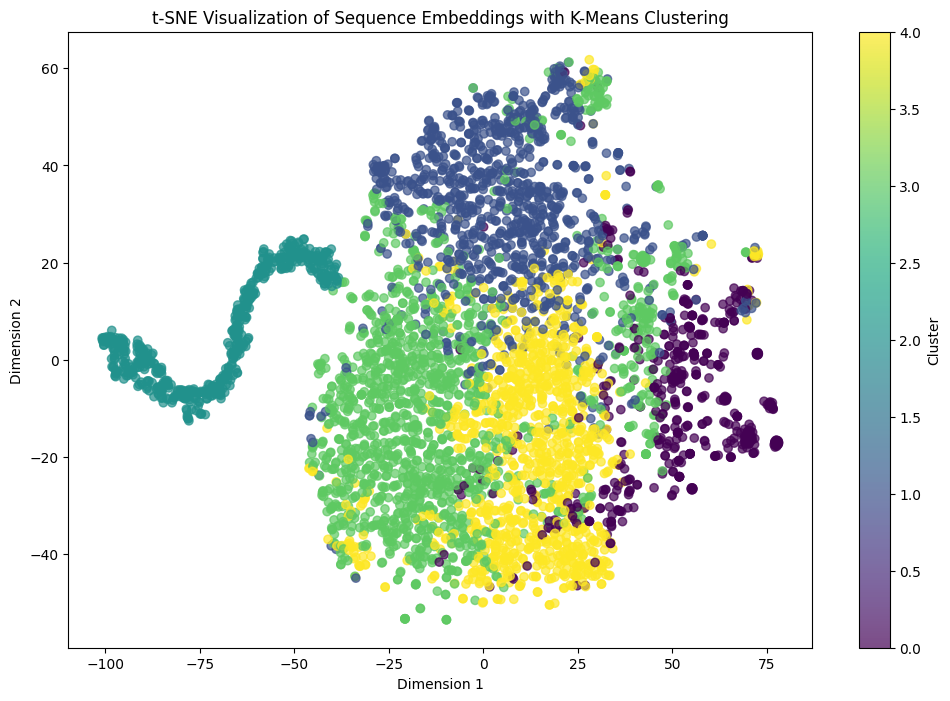

In [12]:
plt.figure(figsize=(12, 8))
plt.scatter(sequence_embeddings_2d[:, 0], sequence_embeddings_2d[:, 1], c=sequence_labels, cmap='viridis', alpha=0.7)
plt.colorbar(label="Cluster")
plt.title('t-SNE Visualization of Sequence Embeddings with K-Means Clustering')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [13]:
# Analyze Clusters
clusters = {}
words = w2v_model.wv.index_to_key
for word, cluster in zip(words, labels):
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(word)

# Print Top Words in Each Cluster
for cluster_id, cluster_words in clusters.items():
    print(f"Cluster {cluster_id}:")
    print(", ".join(cluster_words[:20]))  # Show top 20 words
    print()

Cluster 1:
trump, said, clinton, would, people, one, new, state, president, also, obama, us, campaign, hillary, like, could, time, even, states, many

Cluster 0:
flint, cuomo, touted, stephanopoulos, mcauliffe, snyder, rebellion, merrill, ernst, urgency, baptist, oliver, cheered, lawmaker, hogan, fare, bevin, deportations, solicitor, fec



Accuracy: 0.6608

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68      2412
           1       0.68      0.61      0.64      2396

    accuracy                           0.66      4808
   macro avg       0.66      0.66      0.66      4808
weighted avg       0.66      0.66      0.66      4808



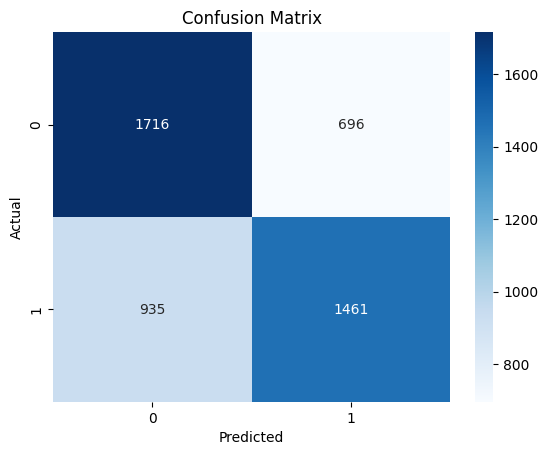

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Map Clusters to Original Labels (if labels are available)
# Here we assume you have `train['label']` to evaluate against
if 'label' in train.columns:
    true_labels = train['label'].values  # Replace with actual labels if available
    predicted_labels = sequence_kmeans.labels_  # Cluster labels

    # Map predicted clusters to actual labels
    # We use the majority vote for each cluster to determine its label
    cluster_mapping = {}
    for cluster_id in np.unique(predicted_labels):
        mask = predicted_labels == cluster_id
        true_labels_in_cluster = true_labels[mask]
        if len(true_labels_in_cluster) > 0:
            cluster_label = np.bincount(true_labels_in_cluster).argmax()
            cluster_mapping[cluster_id] = cluster_label

    # Map predicted clusters to original labels
    mapped_labels = np.array([cluster_mapping[cluster] for cluster in predicted_labels])

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, mapped_labels)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(true_labels, mapped_labels))

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, mapped_labels)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print("No labels available for accuracy calculation.")
